## Ejercicio - matching por propensión 

Veremos cómo hacer matching usando scores de propensión para depender menos de la estimación de los modelos

In [1]:
%autosave 0
import pandas as pd 
import numpy as np
from plotnine import *
import plotnine

Autosave disabled


In [2]:
trafico_df = pd.read_csv("../datos/trafico.csv")

In [3]:
muestra_obs = trafico_df. \
  sample(n = 1200, random_state = 143)[["policia", "tiempo_espera_min", "categoria", "dia_sem", "persistencia", "x_inicial"]]
muestra_obs = muestra_obs.rename(columns = {"x_inicial":"trafico_inicial"})
muestra_obs.columns
muestra_obs

,policia,tiempo_espera_min,categoria,dia_sem,persistencia,trafico_inicial
1455,1,5.400145,Típico,3,0.874011,9.188734
1618,0,0.051465,Fluido,1,0.392589,0.093161
3749,0,1.712431,Fluido,2,0.539080,3.145896
4267,1,5.597704,Típico,2,0.178862,19.834992
3498,0,0.354377,Fluido,2,0.139461,0.703130
...,...,...,...,...,...,...
4854,0,0.517274,Fluido,3,0.658116,0.728284
4441,0,3.281405,Fluido,2,0.765812,3.430704
4278,0,1.113136,Fluido,3,0.087964,2.768910
3450,0,0.922885,Fluido,2,0.022564,2.404028


Vemos cómo los datos tienen mal balance, y tienen zonas donde hay poco traslape:

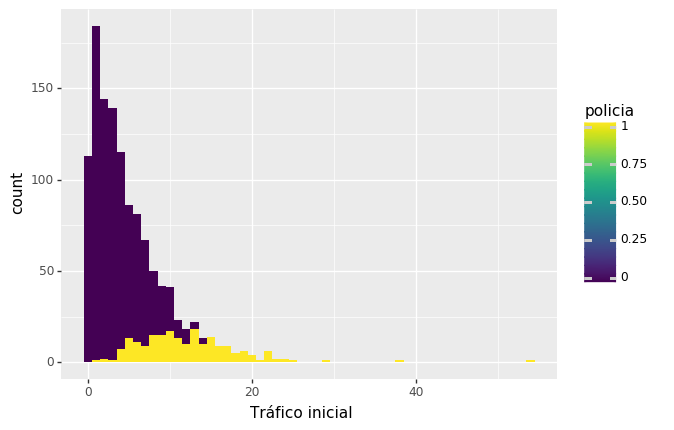

<ggplot: (-9223363263158737036)>

In [4]:
(ggplot(muestra_obs, aes(x = "trafico_inicial", fill = "policia", group = "policia")) 
  + geom_histogram(binwidth = 1) 
  + xlab("Tráfico inicial"))

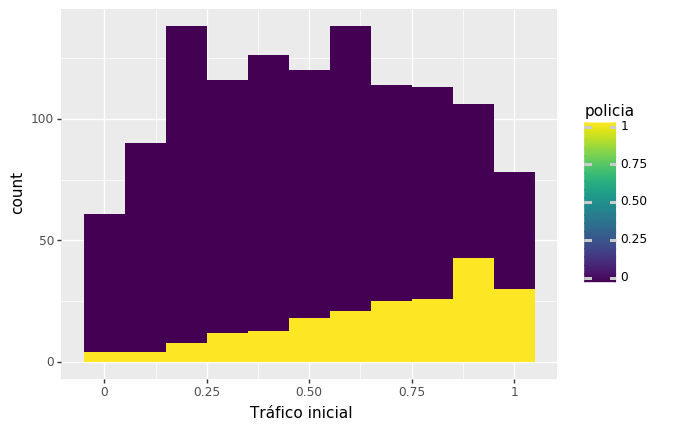

<ggplot: (-9223363263222567150)>

In [5]:
(ggplot(muestra_obs, aes(x = "persistencia", fill = "policia", group = "policia")) 
  + geom_histogram(binwidth = 0.1) 
  + xlab("Tráfico inicial"))

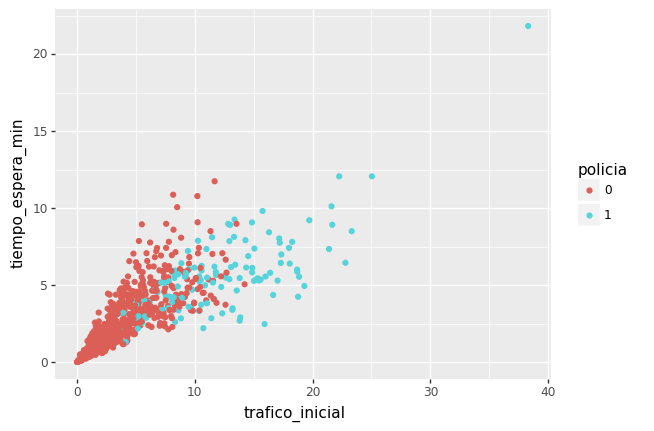

<ggplot: (8773623678563)>

In [6]:
datos_g = muestra_obs.sample(800, random_state=3213)
datos_g["policia"] = pd.Categorical(datos_g["policia"])
(ggplot(datos_g, aes('trafico_inicial', 'tiempo_espera_min', color='policia')) +
  geom_point())

### Mejorando el balance

Utilizaremos matching con score de propensión para mejorar el balance y el traslape. La idea es
emparejar unidades de tratamiento y control dependiendo de la probabilidad de que reciban tratamiento.
Primero ajustamos un modelo logístico donde la variable respuesta es el tratamiento:

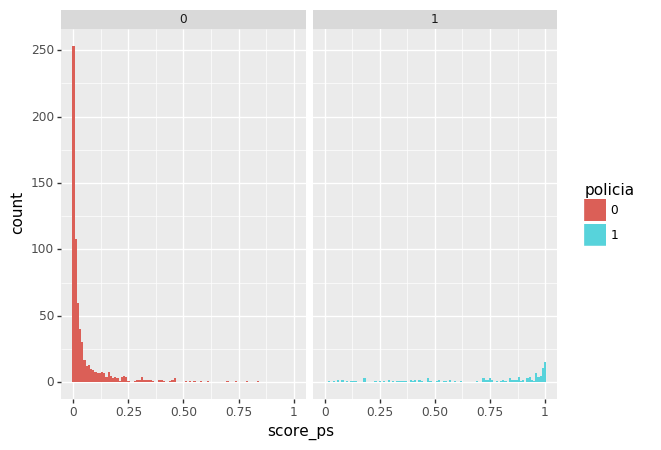

<ggplot: (-9223363263231095692)>

In [7]:
from sklearn.linear_model import LogisticRegression
X = datos_g[["trafico_inicial", "persistencia"]]
mod_propension = LogisticRegression(solver="lbfgs").fit(y = datos_g["policia"], X=X)
score_ps = mod_propension.predict_proba(X)[:, 1]
datos_g["score_ps"] = score_ps
(ggplot(datos_g, aes(x = "score_ps", fill="policia", group="policia")) + 
  geom_histogram(position="dodge", binwidth = 0.01) + facet_wrap("~policia"))

Y vemos que efectivamente la mayor parte de las unidades tiene probabilidad muy alta o muy baja de recibir tratamiento. Esto proviene de la relación fuerte
del tratamiento con las variables de control. Es difícil comparar esas unidades en los extremos, y los grupos están muy desbalanceados.

Podemos empezar recortando los casos con probabilidades extremas de tratamiento como sigue:

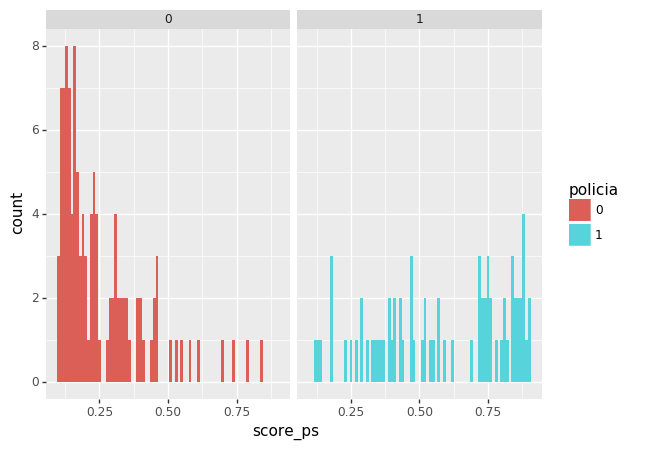

<ggplot: (-9223363263231125090)>

In [8]:
trim = (datos_g.score_ps > 0.10) & (datos_g.score_ps < 0.90)
datos_trim = datos_g[trim].copy()
(ggplot(datos_trim, aes(x = "score_ps", fill="policia", group="policia")) + 
  geom_histogram(position="dodge", binwidth = 0.01) + facet_wrap("~policia"))

In [9]:
datos_trim["policia"].value_counts()


0    112
1     72
Name: policia, dtype: int64

Ahora dividimos los casos según su score de propensión, agrupamos, y seleccionamos pares
de cada estrato:

In [10]:
datos_trim["estrato"] = pd.cut(datos_trim["score_ps"], 30)
agrupados = datos_trim.groupby("estrato").agg({"policia": lambda x: x.nunique()}).reset_index()
agrupados
estratos_selec = agrupados[agrupados["policia"] == 2]["estrato"]

In [11]:
datos_match = datos_trim[datos_trim["estrato"].isin(estratos_selec.tolist())]
datos_match

,policia,tiempo_espera_min,categoria,dia_sem,persistencia,trafico_inicial,score_ps,estrato
4110,0,4.842847,Típico,3,0.906073,4.046926,0.127976,"(0.128, 0.154]"
275,0,5.230198,Típico,1,0.925162,3.956532,0.133150,"(0.128, 0.154]"
4363,0,5.918665,Típico,3,0.852939,5.296831,0.198280,"(0.181, 0.207]"
1965,0,4.387836,Típico,2,0.668131,5.741106,0.107325,"(0.1, 0.128]"
421,1,5.474701,Típico,3,0.793566,8.266523,0.551896,"(0.552, 0.578]"
...,...,...,...,...,...,...,...,...
3097,0,5.927728,Típico,3,0.659356,7.325395,0.242918,"(0.234, 0.26]"
1164,0,3.732510,Típico,1,0.040713,12.606330,0.252409,"(0.234, 0.26]"
299,1,2.187481,Típico,2,0.767537,5.171364,0.125061,"(0.1, 0.128]"
1867,1,4.217324,Típico,2,0.665996,8.216649,0.372558,"(0.366, 0.393]"


Ahora **checamos balance**. Puede ser necesario ajustar el recorte y el número de
segmentos para que este balance sea satisfactorio:

In [12]:
import sys
!{sys.executable} -m pip install causalinference

In [13]:
from causalinference import CausalModel
trafico_causal = CausalModel(
  datos_match["tiempo_espera_min"].to_numpy(), 
  datos_match["policia"].to_numpy(),
  datos_match[["trafico_inicial", "persistencia"]].to_numpy())

In [14]:
trafico_causal.reset()
print(trafico_causal.summary_stats)


Summary Statistics

                       Controls (N_c=112)          Treated (N_t=50)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        5.742        1.699        4.093        1.135       -1.649

                       Controls (N_c=112)          Treated (N_t=50)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        7.681        2.642        8.134        2.456        0.178
             X1        0.605        0.288        0.759        0.224        0.596



Los grupos ahora son similares en las covariables. Podemos ahora graficar también:

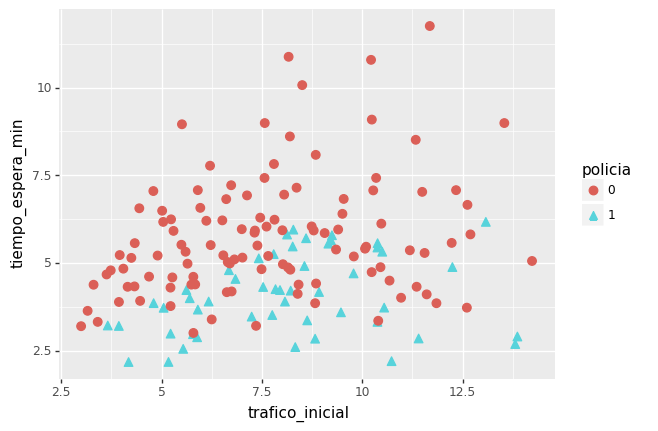

<ggplot: (-9223363263231263400)>

In [15]:
(ggplot(datos_match, aes('trafico_inicial', 'tiempo_espera_min', 
  shape='policia', colour ="policia")) +
  geom_point(size=3))

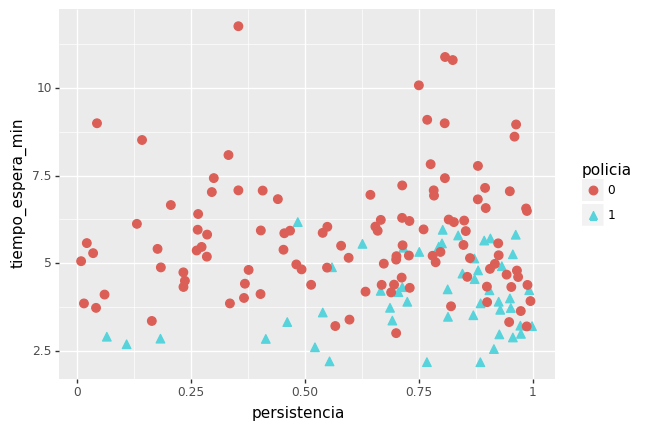

<ggplot: (-9223363263231152289)>

In [16]:
(ggplot(datos_match, aes('persistencia', 'tiempo_espera_min', 
  shape='policia', colour='policia')) +
  geom_point(size=3))

Ahora podemos ajustar un modelo con estas covariables para dar nuestras estimaciones finales.
 
- **ATE**: average treatment effect  es el efecto causal ponderado según proporción de tratamiento en la muestra. Esto promedia efectos sobre los tratados y sobre los no tratados.
- **ATT**: average treament effect on treated es el efecto causal calculando para cada tratado el contrafactual con el modelo, y calculando la diferencia.

In [17]:
trafico_causal.est_via_ols()
print(trafico_causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -2.929      0.183    -15.973      0.000     -3.288     -2.569
           ATC     -2.762      0.175    -15.799      0.000     -3.105     -2.420
           ATT     -3.302      0.270    -12.224      0.000     -3.831     -2.773



/opt/conda/lib/python3.7/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Veamos qué pasa si no hacemos matching antes: obtenemos sesgo en la estimación

In [18]:
from causalinference import CausalModel
trafico_causal = CausalModel(
  datos_g["tiempo_espera_min"].to_numpy(), 
  datos_g["policia"].to_numpy(),
  datos_g[["trafico_inicial", "persistencia"]].to_numpy())
trafico_causal.est_via_ols()
print(trafico_causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -2.542      0.240    -10.600      0.000     -3.012     -2.072
           ATC     -2.494      0.282     -8.841      0.000     -3.047     -1.941
           ATT     -2.784      0.198    -14.084      0.000     -3.172     -2.397



Y el sesgo es mucho más grave si no usamos variables de control adecuadas:

In [19]:
trafico_causal = CausalModel(
  datos_g["tiempo_espera_min"].to_numpy(), 
  datos_g["policia"].to_numpy(),
  datos_g[["dia_sem"]].to_numpy())

In [20]:
trafico_causal.est_via_ols()
print(trafico_causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.916      0.237     12.296      0.000      2.451      3.380
           ATC      2.915      0.237     12.299      0.000      2.450      3.379
           ATT      2.920      0.238     12.280      0.000      2.454      3.386

